Step 0: Importing Relevant Packages (0%)

In [1]:
import math

# Web Scraping Libraries
from bs4 import BeautifulSoup  # for scraping
import requests  # for sending HTTP requests
# Data Processing Libraries
import csv
import re
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

Step 1: Crawl a Real World Data Set (2%)

In [169]:
url = "https://www.worldometers.info/coronavirus/#main_table"  # Web address of data
response = requests.get(url)  # Performing a get request for the data at the url location
soup_object = BeautifulSoup(response.content)  # Parsing the request response to create a soup_object that can be searched for a table
covid_table = soup_object.find("table")  # Searching the soup_object for a table

with open("Live_Covid_Data.csv", "w", newline="") as csv_file:  # Opening a CSV file to be written into
    writer = csv.writer(csv_file)  # Defining the writer as a csv writer that writes to the opened file

    for row in covid_table.find_all("tr"):  # Iterate through the rows of the table, "tr" points to a row in the table
        cells = row.find_all("td")  # Get the cells in the row, "td" points to a cell in the row

        if cells:  # If there are cells...
            values = [cell.text for cell in cells]  # Values is a list of values for each cell in the row of cells
            writer.writerow(values)  # Write the values to the CSV


Step 2: Data Preparation and Cleaning (5%)

In [2]:
# Creating list of column names
col_names = ["Country", "Total Cases", "New Cases", "Total Deaths", "New Deaths", "Total Recovered", "New Recovered", "Active Cases", "Critical Cases",
             "Total Cases / 1M People", "Total Deaths / 1M People", "Total Tests", "Total Tests / 1M People", "Population", "Continent", "One Case / n People",
             "One Death / n People", "One Test / n People", "New Cases / 1M People", "New Deaths / 1M People", "Active Cases / 1M People"]

# Reading the csv to a dataframe with the column names specified, encoding with "latin-1" to get around "utf-8" decoding issue.
df = pd.read_csv("Live_Covid_Data.csv", names=col_names, header=None, encoding="latin-1")

# Tidying up the names of the continent by removing the "\n"'s on it, i.e. "\nNorth America\n"
old_continent_list = df.iloc[0:7]["Country"].tolist()  # Locating the continent names and putting them into a list
new_continent_list = []  # Defining a list for the formatted continent names

for old_continent in old_continent_list:  # Iterate through current continent names
     new_continent = "Antarctica" if old_continent == "\n\n" else old_continent.replace("\n", "")  # Removing \n from continent names/identifying Antarctica
     if new_continent == "Oceania":  # In "Continent" column countries are assigned Australia/Oceania not just Oceania
         new_continent = "Australia/Oceania"  # Renaming continent
     new_continent_list.append(new_continent)  # Addding the renamed continenet to the new list

# Changing the index to the name of the Country/Continent
df.set_index("Country", inplace=True)  # inplace=True updates the original datafram immediately

# Changing the index name to the re-formatted continents. set_value has been depricated, also before setting the index as Country the continent rows had
# an index of NaN so at[row, col] couldn't be used to assign values either. Therefore, application of the reformatted names had to after set_index was done.
n = 0
for new_continent in new_continent_list:  # Iterate through the new continent names
    df.rename(index={old_continent_list[n]: new_continent}, inplace=True)  # Replace the old continent name with corresponding new continent name
    n += 1

# Moving country continent and population to first/second column as it is important for comparison to total cases etc
pop_col = df.pop("Continent")
df.insert(0, "Continent", pop_col)
pop_col = df.pop("Population")  # Removes the column from DF while saving it to a variable
df.insert(1, "Population", pop_col)  # Replacing the column in first position using previously assigned variable
pop_col = df.pop("Total Tests")
df.insert(5, "Total Tests", pop_col)

# Removing non-ccountries/non-territories from the DF
drop_list = ["Diamond Princess", "MS Zaandam", "Total:"]  # List of unwanted non-countries/non-territories
for item in drop_list:  # Iterate through list
    df.drop(index=item, axis=0, inplace=True)  # Permanently delete the corresponding row in place

# Calculating the population of each continent and the world
global_population = 0  # Defining global population as 0
for continent in new_continent_list:  # iterate through the continents
    # If a row has continent "continent" and is not the row for the continent itself, population is added to the corresponding list
    population_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Population"].tolist()
    continent_population = 0  # Defining the continent's population as 0

    for population in population_list:  # Iterate through all populations in the list
        new_population = re.sub(",", "", population)  # Removing the commas from the strings seperating 1000's
        continent_population += int(new_population)  # Adding the population to the continent populatuon

    global_population += continent_population  # Adding the continent population to the global population
    df.at[continent, "Population"] = continent_population  # Replacing the continents NaN population with the calculated population
df.at["World", "Population"] = global_population  # Replacing the world's NaN population with the calculated population

# Dropping Antarctica as its data is not useful
df.drop(index="Antarctica", axis=0, inplace=True)

# Handling missing values
df = df.replace(r"^\s*$", np.nan, regex=True)

# Remove commas from all columns and convert all columns to floats while avoiding non-numeric data
df = df.replace(",", "", regex=True)  # Removing commas from entire dataframe, regex=True automates searching and replacing
for column in df:  # Iterate through all columns in the dataframe
    try:  # Try the following experssion:
        df[column] = df[column].astype(float)  # Convert the column to floats
    except ValueError:  # If this error is caused, raise an exception for the Nan/string value
        pass  # Skip the conversion if the column contains non-numeric data

# Dropping columns with the format "New..." as "New" is ambiguous and not described on the website, they also contain a lot of NaN.
for column in df:
    if "New" in column:
        df.drop(columns=column, inplace=True)

# Calculating the total tests taken in each continent
global_total_tests = 0  # Defining the global total as 0
for continent in new_continent_list[:-1]:  # Iterating through continents, except antarctica
    continent_total_tests = 0  # Defining the continent total as 0
    test_list = df.loc[(df["Continent"] == continent) & (df.index != continent), "Total Tests"].tolist()  # Adding all test numbers to a list
    clean_test_list = [x for x in test_list if (math.isnan(x) == False)]  # Removing nan values from the list
    continent_total_tests = sum(clean_test_list)  # Summing all the values in the list
    global_total_tests += continent_total_tests  # Adding the continent total to the global total
    df.at[continent, "Total Tests"] = continent_total_tests  # Reassigning the continent total tests value to new calculated value
df.at["World", "Total Tests"] = global_total_tests  # Reassign global test total after for loop has completed

# Recalculating X/1M based on the live data from other columns where x = Total Cases, Total Deaths, Total Tests, Active Cases
for column in df:  # Iterate through columns in the DF
    if "1M People" in column:  # Checking if the column is a target for recalculation
        reduced_column = column.replace(" / 1M People", "")  # Formulating the column from which x/1M column will be calculated
        df[column] = (df[reduced_column] / df["Population"]) * 1000000  # Recalculating column

# Recalculating how many people there where per one case/death/test
df["One Case / n People"] = df["Population"] / df["Total Cases"]
df["One Death / n People"] = df["Population"] / df["Total Deaths"]
df["One Test / n People"] = df["Population"] / df["Total Tests"]

df

,Continent,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
Country,,,,,,,,,,,,,,,
North America,North America,5.981409e+08,121337450.0,1578727.0,1.287663e+09,116142918.0,3615805.0,9668.0,202857.632297,2639.389745,2.152775e+06,4.929566,378.875459,0.464517,6045.072162
Asia,Asia,4.711357e+09,206878311.0,1511747.0,2.348238e+09,193434481.0,11932083.0,11669.0,43910.559214,320.872961,4.984208e+05,22.773566,3116.498186,2.006337,2532.621398
Europe,Europe,7.475438e+08,242793984.0,1980561.0,2.806916e+09,236914861.0,3898562.0,7553.0,324788.958162,2649.424558,3.754851e+06,3.078922,377.440451,0.266322,5215.161716
South America,South America,4.376944e+08,66824087.0,1341748.0,2.409430e+08,64282682.0,1199657.0,10341.0,152672.916160,3065.490141,5.504821e+05,6.549950,326.212108,1.816589,2740.854994
Australia/Oceania,Australia/Oceania,4.346903e+07,13626060.0,23363.0,8.844942e+07,13343309.0,259388.0,176.0,313465.931952,537.463109,2.034769e+06,3.190139,1860.592818,0.491456,5967.190894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wallis and Futuna,Australia/Oceania,1.098200e+04,761.0,7.0,2.050800e+04,438.0,316.0,NaN,69295.210344,637.406665,1.867419e+06,14.431012,1568.857143,0.535498,28774.358040
Niue,Australia/Oceania,1.622000e+03,483.0,NaN,NaN,320.0,163.0,NaN,297780.517879,NaN,NaN,3.358178,NaN,NaN,100493.218249
Vatican City,Europe,7.990000e+02,29.0,NaN,NaN,29.0,0.0,NaN,36295.369212,NaN,NaN,27.551724,NaN,NaN,0.000000


Step 3: Exploratory Data Analysis (8%)

In [3]:
# Displaying descriptive statistics for countries
df.loc["USA":].describe()  # Dont want continent totals included as these are just totals of other countries

,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
count,2.280000e+02,2.280000e+02,2.230000e+02,2.130000e+02,2.080000e+02,2.090000e+02,141.000000,228.000000,223.000000,2.130000e+02,228.000000,223.000000,213.000000,209.000000
mean,3.484620e+07,2.913158e+06,3.002011e+04,3.230997e+07,2.967280e+06,9.472914e+04,285.460993,191098.056770,1226.627317,2.111796e+06,408.039211,14595.683913,10.784514,13717.164269
std,1.389233e+08,9.364014e+06,1.048454e+05,1.170979e+08,9.372213e+06,5.840101e+05,962.722624,192182.699321,1265.866334,3.597885e+06,4157.846165,57241.134996,26.761690,47616.501755
min,7.990000e+02,1.000000e+01,1.000000e+00,7.850000e+03,2.000000e+00,0.000000e+00,1.000000,15.970334,1.597033,5.090634e+03,1.420538,154.388655,0.044340,0.000000
25%,5.170965e+05,2.681875e+04,2.250000e+02,3.478150e+05,2.300425e+04,1.230000e+02,5.000000,17146.415605,157.534006,1.865962e+05,3.253494,505.535822,0.409986,52.277325
50%,5.816378e+06,2.077620e+05,2.230000e+03,2.213831e+06,2.425435e+05,1.620000e+03,21.000000,123691.482623,787.918582,8.844286e+05,8.084673,1269.166667,1.130674,552.311537
75%,2.254928e+07,1.295452e+06,1.479300e+04,1.290153e+07,1.484750e+06,1.554900e+04,87.000000,307378.096250,1978.117711,2.439107e+06,58.321545,6356.462575,5.359166,3288.029355
max,1.448471e+09,1.024779e+08,1.117751e+06,1.151834e+09,9.943788e+07,7.957453e+06,8318.000000,703958.726870,6477.159861,2.255304e+07,62616.100000,626161.000000,196.439191,340116.235861


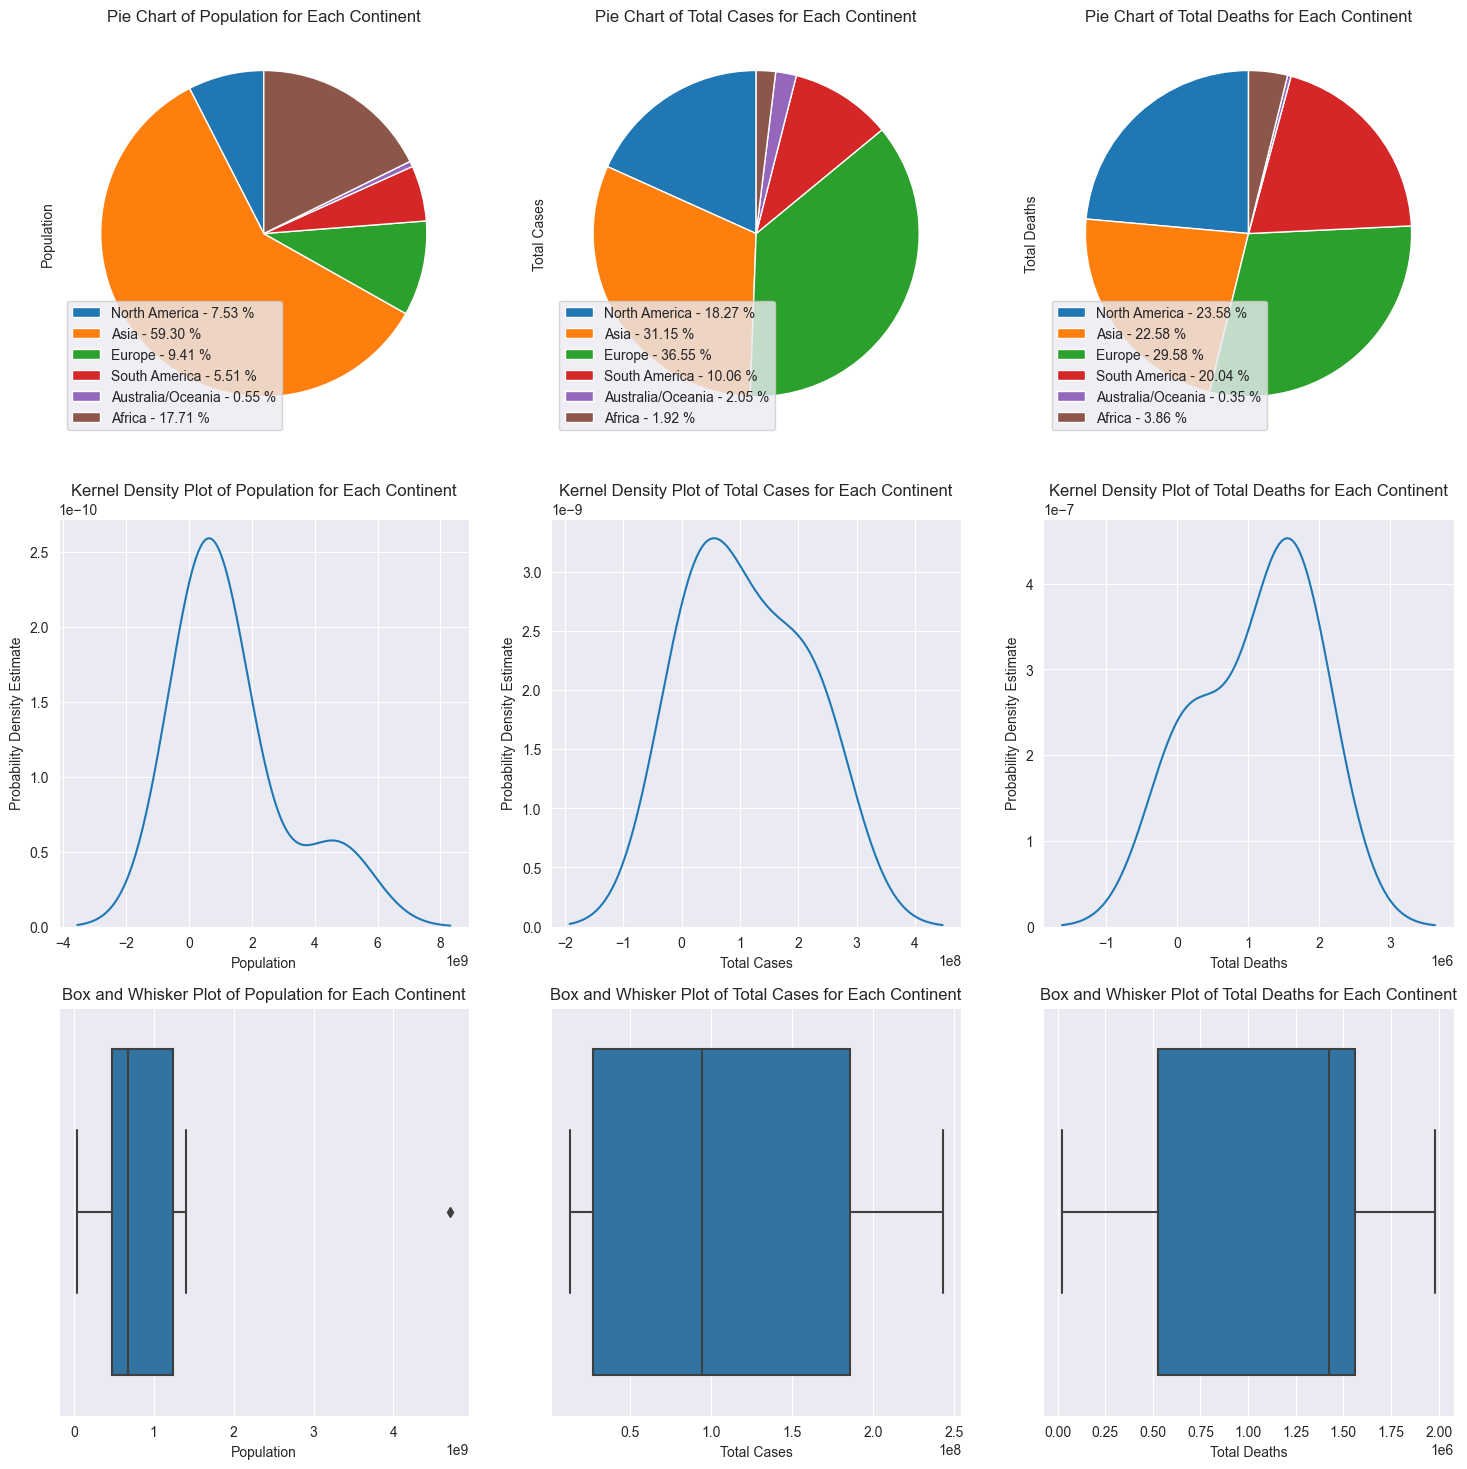

In [7]:
# Pie charts showing the share of population, total cases, and total deaths that each continent has
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 1 + i, aspect="equal")  # Defining the axis and position of the chart
    PC = df.loc[:"Africa"].plot(kind="pie", y=plot_data[i], ax=ax, startangle=90, shadow=False, labels=None)  # Plotting the desired data
    x = np.char.array(new_continent_list[:-1])  # Creating an array of continent names for the legend
    y = df[plot_data[i]].head(6)  # Creating an array of continent data for the legend
    percent = 100.*y/y.sum()  # Calculating the percentage for each continent
    label = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, percent)]  # Formattingg the x and y data into a string
    plt.legend(label)  # Defining the legend
    PC.set_title(f"Pie Chart of {plot_data[i]} for Each Continent")

for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc[:"Africa"][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Continent")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    #BWP = sns.boxplot(data=df.loc[:"Africa"][plot_data[i]])
    BWP = sns.boxplot(x=df.loc[:"Africa"][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Continent")

plt.show()  # Showing the figure

In [45]:
# Due the poisitive skew of these distributions it is worth calculating the central tendency of the distributions
df2 = DataFrame()
df2["Mean"] = df.loc["USA":].mean(numeric_only=True)
df2["Median"] = df.loc["USA":].median(numeric_only=True)
print(df2)

# Displaying descriptive statistics for Continents
df.loc[:"Africa"].describe()



                                  Mean        Median
Population                3.484620e+07  5.816378e+06
Total Cases               2.913158e+06  2.077620e+05
Total Deaths              3.002011e+04  2.230000e+03
Total Tests               3.230997e+07  2.213831e+06
Total Recovered           2.967280e+06  2.425435e+05
Active Cases              9.472914e+04  1.620000e+03
Critical Cases            2.854610e+02  2.100000e+01
Total Cases / 1M People   1.910981e+05  1.236915e+05
Total Deaths / 1M People  1.226627e+03  7.879186e+02
Total Tests / 1M People   2.111796e+06  8.844286e+05
One Case / n People       4.080392e+02  8.084673e+00
One Death / n People      1.459568e+04  1.269167e+03
One Test / n People       1.078451e+01  1.130674e+00
Active Cases / 1M People  1.371716e+04  5.523115e+02


,Population,Total Cases,Total Deaths,Total Tests,Total Recovered,Active Cases,Critical Cases,Total Cases / 1M People,Total Deaths / 1M People,Total Tests / 1M People,One Case / n People,One Death / n People,One Test / n People,Active Cases / 1M People
count,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000e+00,6.000000,6.000000,6.000000,6.000000e+00,6.000000,6.000000,6.000000,6.000000
mean,1.324156e+09,1.107000e+08,1.115748e+06,1.147004e+09,1.060260e+08,3.558211e+06,6708.333333,174458.759836,1566.047621,1.511560e+06,25.156555,1917.483528,2.975871,3802.727139
std,1.718459e+09,9.773109e+07,7.872226e+05,1.202938e+09,9.385181e+07,4.390573e+06,4987.004779,132366.159845,1348.597733,1.394438e+06,42.427198,2057.057510,4.874731,2306.935087
min,4.346903e+07,1.274012e+07,2.336300e+04,8.844942e+07,1.203802e+07,2.593880e+05,176.000000,9056.561227,183.645213,7.806397e+04,3.078922,326.212108,0.266322,315.461671
25%,4.778061e+08,2.692557e+07,5.291912e+05,1.425969e+08,2.607815e+07,6.327410e+05,2520.500000,71101.148451,375.020498,5.114362e+05,3.624996,377.799203,0.471252,2584.679797
50%,6.728424e+08,9.408077e+07,1.426748e+06,7.643030e+08,9.021280e+07,2.407731e+06,8610.500000,177765.274229,1588.426427,1.292625e+06,5.739758,1119.734138,1.154023,3978.008355
75%,1.241933e+09,1.854931e+08,1.561982e+06,2.083095e+09,1.741116e+08,3.827873e+06,10172.750000,285813.857038,2646.915855,2.123274e+06,18.717662,2802.521844,1.958900,5779.183600
max,4.711357e+09,2.427940e+08,1.980561e+06,2.806916e+09,2.369149e+08,1.193208e+07,11669.000000,324788.958162,3065.490141,3.754851e+06,110.417185,5445.282145,12.810006,6045.072162


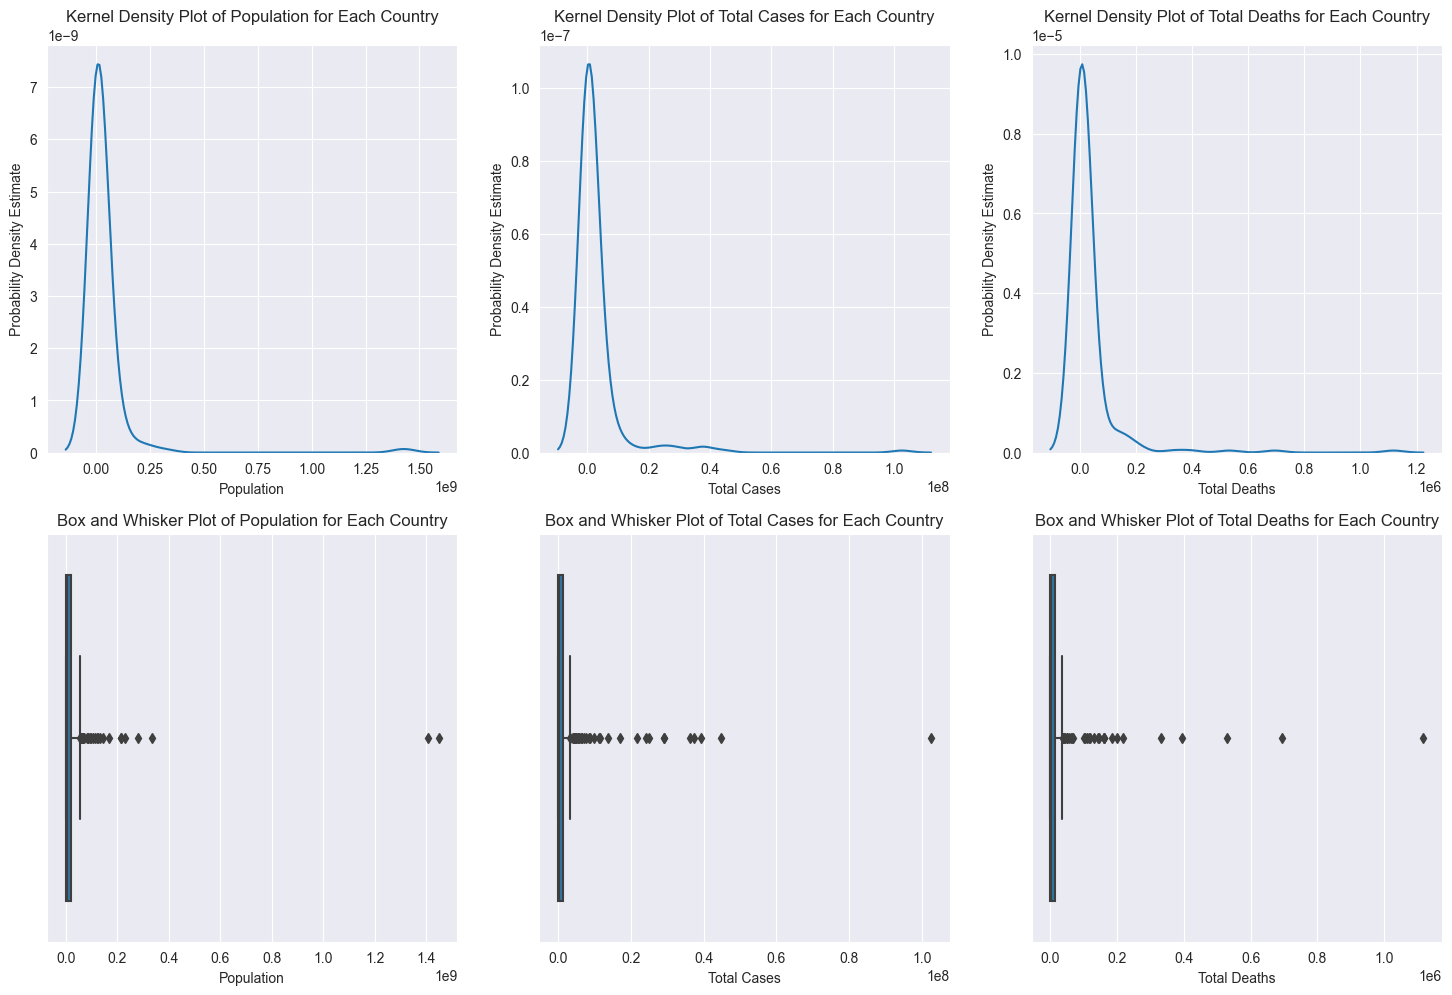

In [29]:
# Country Data Distributions
fig = plt.figure(figsize=(18, 18))  # Setting the figure size
plot_data = ["Population", "Total Cases", "Total Deaths"]  # List of the column titles we wish to plot
for i in range(3):  # Iterating through the column titles
    ax = plt.subplot(3, 3, 4 + i)  # Defining the axis and position of the chart
    KDE = sns.kdeplot(data=df.loc["USA":][plot_data[i]])
    KDE.set_title(f"Kernel Density Plot of {plot_data[i]} for Each Country")
    KDE.set_ylabel("Probability Density Estimate")
    KDE.set_xlabel(plot_data[i])

for i in range(3):
    ax = plt.subplot(3, 3, 7 + i)
    BWP = sns.boxplot(x=df.loc["USA":][plot_data[i]])
    BWP.set_xlabel(plot_data[i])
    BWP.set_title(f"Box and Whisker Plot of {plot_data[i]} for Each Country")

plt.show()

In [171]:
# Relationships between columns

Step 4a: Question 1 (10%)

Step 4b: Question 2 (10%)

Step 4c: Question 3 (10%)

Step 5: Summary and Conclusion (5%)

Write summary/conc in here